In [1]:

# Please note that block size = 512B (as per blktrace)



# Blktrace gets its data from the Linux kernel which considers sectors to be 512 bytes long.
# So I think that, regardless of the device physical sector size,
# blktrace displays offsets and sizes in 512-bytes sectors.


# Since default linux block size = 4096, so blktrace works in multiples of 8 blocks at a time (512*8)






# Handler Methods

In [2]:
def sizeof_fmt(num, suffix='B'):
    for unit in ['','K','M','G','T','P','E','Z']:
        if abs(num) < 1024.0:
            return "%3.4f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Y', suffix)

In [3]:
import math

def count_blocks(data):
    block_counter_dict = {}
    block_read_counter_dict = {}
    block_write_counter_dict = {}
    
    for row in data.itertuples():
        flag_r = False
        
#         print (type(row.PID))
#         if (isinstance(row.PID, float) and not math.isnan(row.PID)):
#         process_id = int(row.PID)

        # Trace event PID will be greater than 2000, ignore others
#         if process_id > 1000:

        if (row.Start_Block.isdigit()):
            start_block = int(row.Start_Block)
        else:
            continue


        # Find "R" because Activity can be RWBS (man blkparse)
        if (row.Activity.find("R") >= 0):
            flag_r = True  # else flag = Write



        if (math.isnan(row.Number_of_Blocks)):
            next_blocks_count = 0
        else:
            next_blocks_count = int(row.Number_of_Blocks)



        # Incrememnt next blocks counter
        for i in range(0, next_blocks_count):
            if (start_block+i in block_counter_dict):
                block_counter_dict[start_block+i] += 1
            else:
                block_counter_dict[start_block+i] = 1



        # Read and Write counters
        for i in range(0, next_blocks_count):
            if (flag_r):
                if (start_block+i in block_read_counter_dict):
                    block_read_counter_dict[start_block+i] += 1
                else:
                    block_read_counter_dict[start_block+i] = 1
            else:        # else means write
                if (start_block+i in block_write_counter_dict):
                    block_write_counter_dict[start_block+i] += 1
                else:
                    block_write_counter_dict[start_block+i] = 1
                    
    return (block_counter_dict, block_read_counter_dict, block_write_counter_dict)

In [4]:
import math

def count_blocks_time_window(data, time_window):
    list_of_block_counter_dict = []
    block_counter_dict = {}
    index_of_list_of_block_counter_dict = 0
    
    for row in data.itertuples():
        
#         process_id = int(row.PID)

#         # Trace event PID will be greater than 2000, ignore others
#         if process_id > 2000:

        if (row.Start_Block.isdigit()):
            start_block = int(row.Start_Block)
        else:
            continue

        if (math.isnan(row.Number_of_Blocks)):
            next_blocks_count = 0
        else:
            next_blocks_count = int(row.Number_of_Blocks)

        # Incrememnt next blocks counter
        for i in range(0, next_blocks_count):
            if (start_block+i in block_counter_dict):
                block_counter_dict[start_block+i] += 1
            else:
                block_counter_dict[start_block+i] = 1

        if (int(row.Timestamp) > time_window*(index_of_list_of_block_counter_dict+1)):
            list_of_block_counter_dict.append(block_counter_dict.copy())
            index_of_list_of_block_counter_dict += 1
                
    # Append final dict to the list, after loop exit
    list_of_block_counter_dict.append(block_counter_dict.copy())
                    
    return list_of_block_counter_dict

In [5]:
def block_range_count(block_counter_dict):
    block_range_2000_plus = 0
    block_range_1000_2000 = 0
    block_range_500_1000 = 0
    block_range_100_500 = 0
    block_range_50_100 = 0
    block_range_10_50 = 0
    block_range_2_10 = 0
    block_range_1 = 0
    block_range_0 = 0




    io_range_2000_plus = 0
    io_range_1000_2000 = 0
    io_range_500_1000 = 0
    io_range_100_500 = 0
    io_range_50_100 = 0
    io_range_10_50 = 0
    io_range_2_10 = 0
    io_range_1 = 0

    for i in block_counter_dict.values():
        if i >= 2000:
            block_range_2000_plus += 1
            io_range_2000_plus += i

        elif i >= 1000 and i < 2000:
            block_range_1000_2000 += 1
            io_range_1000_2000 += i

        elif i >= 500 and i < 1000:
            block_range_500_1000 += 1
            io_range_500_1000 += i

        elif i >= 100 and i < 500:
            block_range_100_500 += 1
            io_range_100_500 += i

        elif i >= 50 and i < 100:
            block_range_50_100 += 1
            io_range_50_100 += i

        elif i >=10 and i <= 50:
            block_range_10_50 += 1
            io_range_10_50 += i

        elif i >=2 and i <= 10:
            block_range_2_10 += 1
            io_range_2_10 += i

        elif i == 1:
            block_range_1 += 1
            io_range_1 += i

    total_number_of_blocks = max(block_counter_dict)
    block_range_0 = (total_number_of_blocks - (len(block_counter_dict)))


#     print("block_range_2000_plus", block_range_2000_plus)
#     print("block_range_1000_2000", block_range_1000_2000)
#     print("block_range_500_1000", block_range_500_1000)
#     print("block_range_100_500", block_range_100_500)
#     print("block_range_50_100", block_range_50_100)
#     print("block_range_10_50", block_range_10_50)
#     print("block_range_2_10", block_range_2_10)
#     print("block_range_1", block_range_1)
#     print("block_range_0", block_range_0)

    number_of_blocks_total_accessed = block_range_2000_plus + block_range_1000_2000 + block_range_500_1000 + block_range_100_500 + block_range_50_100 + block_range_10_50 + block_range_2_10 + block_range_1
#     print("sum of all accessed blocks = ", number_of_blocks_total_accessed)



#     print("\n\n\n")


#     print("io_range_2000_plus", io_range_2000_plus)
#     print("io_range_1000_2000", io_range_1000_2000)
#     print("io_range_500_1000", io_range_500_1000)
#     print("io_range_100_500", io_range_100_500)
#     print("io_range_50_100", io_range_50_100)
#     print("io_range_10_50", io_range_10_50)
#     print("io_range_2_10", io_range_2_10)
#     print("io_range_1", io_range_1)

    total_IOs_block = io_range_2000_plus + io_range_1000_2000 + io_range_500_1000 + io_range_100_500 + io_range_50_100 + io_range_10_50 + io_range_2_10 + io_range_1
#     print("sum of all IOs = ", total_IOs_block)
    
    list_block_range = [block_range_1, block_range_2_10, block_range_10_50, 
                        block_range_50_100, block_range_100_500,
                        block_range_500_1000, block_range_1000_2000,
                        block_range_2000_plus, number_of_blocks_total_accessed]
    
    list_io_range = [io_range_1, io_range_2_10, io_range_10_50, 
                     io_range_50_100, io_range_100_500, io_range_500_1000, 
                     io_range_1000_2000, io_range_2000_plus, total_IOs_block]
    
    return (list_block_range, list_io_range)


In [6]:
import math
import matplotlib.pyplot as pyplot
import pandas as pd
import numpy as np
import datetime


def plot_dual_bar_graph(list_block_range, list_io_range, time_slot, time_window):

    x_axis = ["1", "2-10", "10-50", "50-100", "100-500", "500-1000", "1000-2000", "2000+"]
    y_axis = list_block_range[:-1]
    y_axis_io = list_io_range[:-1]

    _X = np.arange(len(x_axis))
    pyplot.figure(figsize=(8,8))


    pyplot.bar(_X-0.2, y_axis, width=0.35, label='% of total access')
    pyplot.bar(_X+0.2, y_axis_io, width=0.35, label="% of total IO access")
    pyplot.legend(loc='upper right')
    pyplot.title("PDF (Discrete) of total access from T = {} to {}".
                 format(str(datetime.timedelta(seconds=time_window*time_slot)),
                        str(datetime.timedelta(seconds=time_window*(time_slot+1)))))
    pyplot.ylabel('No of blocks')
    pyplot.xlabel('Range of block accesses i.e. 50-100 means "count of blocks that are accessed >=50 and <100" ')
    pyplot.text(5, (max(y_axis_io)*0.75),
                "Blocks Touched = {}, Total IO over these blocks = {}".
                format(sizeof_fmt(list_block_range[-1]*512), sizeof_fmt(list_io_range[-1]*512)),
                bbox=dict(facecolor='yellow', alpha=0.5))

    for i in range(len(_X)):
        pyplot.annotate(str(round(y_axis[i]/list_block_range[-1], 3)), xy=(_X[i]-0.2, y_axis[i]), rotation=45)
        pyplot.annotate(str(round(y_axis_io[i]/list_io_range[-1], 3)), xy=(_X[i]+0.2, y_axis_io[i]), rotation=45)

    pyplot.xticks(_X, x_axis, rotation=45) # set labels manually
    fig = pyplot.figure()
    
    return fig













    #------------------------------- Using Dataframe to plot multiple bars ---------------------------------
    # dfPlot = pd.DataFrame(np.c_[y_axis, y_axis_io], index=x_axis)
    # dfPlot.plot.bar(figsize=(10,10), legend = True)
    # pyplot.show()




In [7]:
trace_file = 'trace_1.txt'

trace_file_csv = 'extracted_webproxy_21Apr_1900.csv'

# Load Trace File  and generate csv

In [8]:
import sys
import csv
import re
import collections
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:

listOfData = []

with open(trace_file) as f:
    print ("yes")
    for line in f:
#         print (line)
#         new_line = line.split(' ')
        listOfData.append([line])
# print (listOfData[100].split(' '))


print (len(listOfData))

x = listOfData[4369][0]
print(x)
# # y = re.split("[%D] [%2c] [%8s] [%5T.%9t] [%5p] [%2a] [%3d]", x)
# y = x.extract(" ")
# # y = x.split()
# print (y)



list_of_list = []

for i in listOfData:
    strr = i[0]
    split_str = strr.split()
    list_of_list.append(split_str)
    
print(list_of_list[4369])

yes
654957
  8,6    6     3184     6.498695730 10121  D  RA 1167356328 + 112 [kworker/6:2H]

['8,6', '6', '3184', '6.498695730', '10121', 'D', 'RA', '1167356328', '+', '112', '[kworker/6:2H]']


In [10]:
with open(trace_file_csv, 'w') as out_file:
    writer = csv.writer(out_file)
#     writer.writerow(('Dev <mjr, mnr>', 'CPU', 'Sequence_Number', 'Timestamp', 'PID', 'Event', 'Activity', 'Start_Block', '+', 'Number_of_Blocks', 'Process'))
    writer.writerows(list_of_list)

# print listOfData

In [9]:
import pandas as pd


# data = pd.read_csv('extracted.csv')

data = pd.read_csv(trace_file_csv, names=['Dev <mjr, mnr>', 'CPU', 'Sequence_Number', 'Timestamp', 'PID', 'Event', 'Activity', 'Start_Block', '+', 'Number_of_Blocks', 'Process'])

print(data.shape)
data[:40]

(654956, 11)


,"Dev <mjr, mnr>",CPU,Sequence_Number,Timestamp,PID,Event,Activity,Start_Block,+,Number_of_Blocks,Process
0,"8,6",6,1,0.000000,0,C,RA,1166977528,+,104.0,[0]
1,"8,6",6,2,0.000023,10121,D,R,1130649592,+,8.0,[kworker/6:2H]
2,"8,6",2,1,0.000226,1736,I,RA,1162077808,+,96.0,[filebench]
3,"8,6",6,3,0.003034,0,C,RA,1171355808,+,40.0,[0]
4,"8,6",6,4,0.003052,10121,D,RA,1132233680,+,16.0,[kworker/6:2H]
5,"8,6",4,1,0.003238,1769,I,RA,1172530376,+,48.0,[filebench]
6,"8,6",6,5,0.005025,0,C,RA,1170426520,+,40.0,[0]
7,"8,6",6,6,0.005037,10121,D,RA,1133530176,+,48.0,[kworker/6:2H]
8,"8,6",7,1,0.005466,1728,I,RA,1187962376,+,80.0,[filebench]
9,"8,6",6,7,0.011436,0,C,RA,1173752968,+,80.0,[0]


In [10]:
#make a cleaned csv, with only necessary pid

data_cleaned = pd.DataFrame()
# data_cleaned_2 = pd.DataFrame()

# for row in data.itertuples:
#         process_id = int(row.PID)

#         # Trace event PID will be greater than 2000, ignore others
#         if process_id > 5500:
            
            
            
# ----------------------We should not filter by filebench as some sycalls are I by filebench and D by kworker
# data_cleaned = data_cleaned.append(data[data['Process'] == '[filebench]'])
data_cleaned = data_cleaned.append(data[data['Event'] == 'D'])

print (data_cleaned.shape)
data_cleaned[:40] 
# print(data_cleaned)

(221995, 11)


,"Dev <mjr, mnr>",CPU,Sequence_Number,Timestamp,PID,Event,Activity,Start_Block,+,Number_of_Blocks,Process
1,"8,6",6,2,0.000023,10121,D,R,1130649592,+,8.0,[kworker/6:2H]
4,"8,6",6,4,0.003052,10121,D,RA,1132233680,+,16.0,[kworker/6:2H]
7,"8,6",6,6,0.005037,10121,D,RA,1133530176,+,48.0,[kworker/6:2H]
10,"8,6",6,8,0.011451,10121,D,RM,1148090392,+,8.0,[kworker/6:2H]
13,"8,6",6,11,0.017751,10121,D,RA,1150739072,+,128.0,[kworker/6:2H]
16,"8,6",6,14,0.021021,10121,D,RA,1155593536,+,56.0,[kworker/6:2H]
19,"8,6",6,16,0.027686,10121,D,RA,1156713000,+,40.0,[kworker/6:2H]
22,"8,6",6,18,0.030431,10121,D,RA,1159514856,+,24.0,[kworker/6:2H]
25,"8,6",6,20,0.037383,10121,D,RA,1159659184,+,56.0,[kworker/6:2H]
28,"8,6",6,22,0.043704,10121,D,RA,1160482088,+,8.0,[kworker/6:2H]


# Block trace analysis

In [11]:
block_counter_dict, block_read_counter_dict, block_write_counter_dict = count_blocks(data_cleaned)


print ("Number of blocks accessed", len(block_counter_dict))
print ("Sum of all the block accesses", sum(block_counter_dict.values()))

print(sum(block_read_counter_dict.values()), sum(block_write_counter_dict.values()))

Number of blocks accessed 12197728
Sum of all the block accesses 12506336
10687208 1819128


In [ ]:
# print(sorted(block_counter_dict.values(), reverse=True))

In [12]:
import collections

sorted_block_counter_dict = collections.OrderedDict(sorted(block_counter_dict.items()))


In [ ]:
import collections

sorted_block_read_counter_dict = collections.OrderedDict(sorted(block_read_counter_dict.items()))
sorted_block_write_counter_dict = collections.OrderedDict(sorted(block_write_counter_dict.items()))

In [13]:

sorted_df = pd.DataFrame.from_dict(sorted_block_counter_dict, orient='index')

print(sorted_df)

            0
833940592   4
833940593   4
833940594   4
833940595   4
833940596   4
...        ..
1488292587  1
1488292588  1
1488292589  1
1488292590  1
1488292591  1

[12197728 rows x 1 columns]


In [ ]:
sorted_read_df = pd.DataFrame.from_dict(sorted_block_read_counter_dict, orient='index')
sorted_write_df = pd.DataFrame.from_dict(sorted_block_write_counter_dict, orient='index')

### All access plots

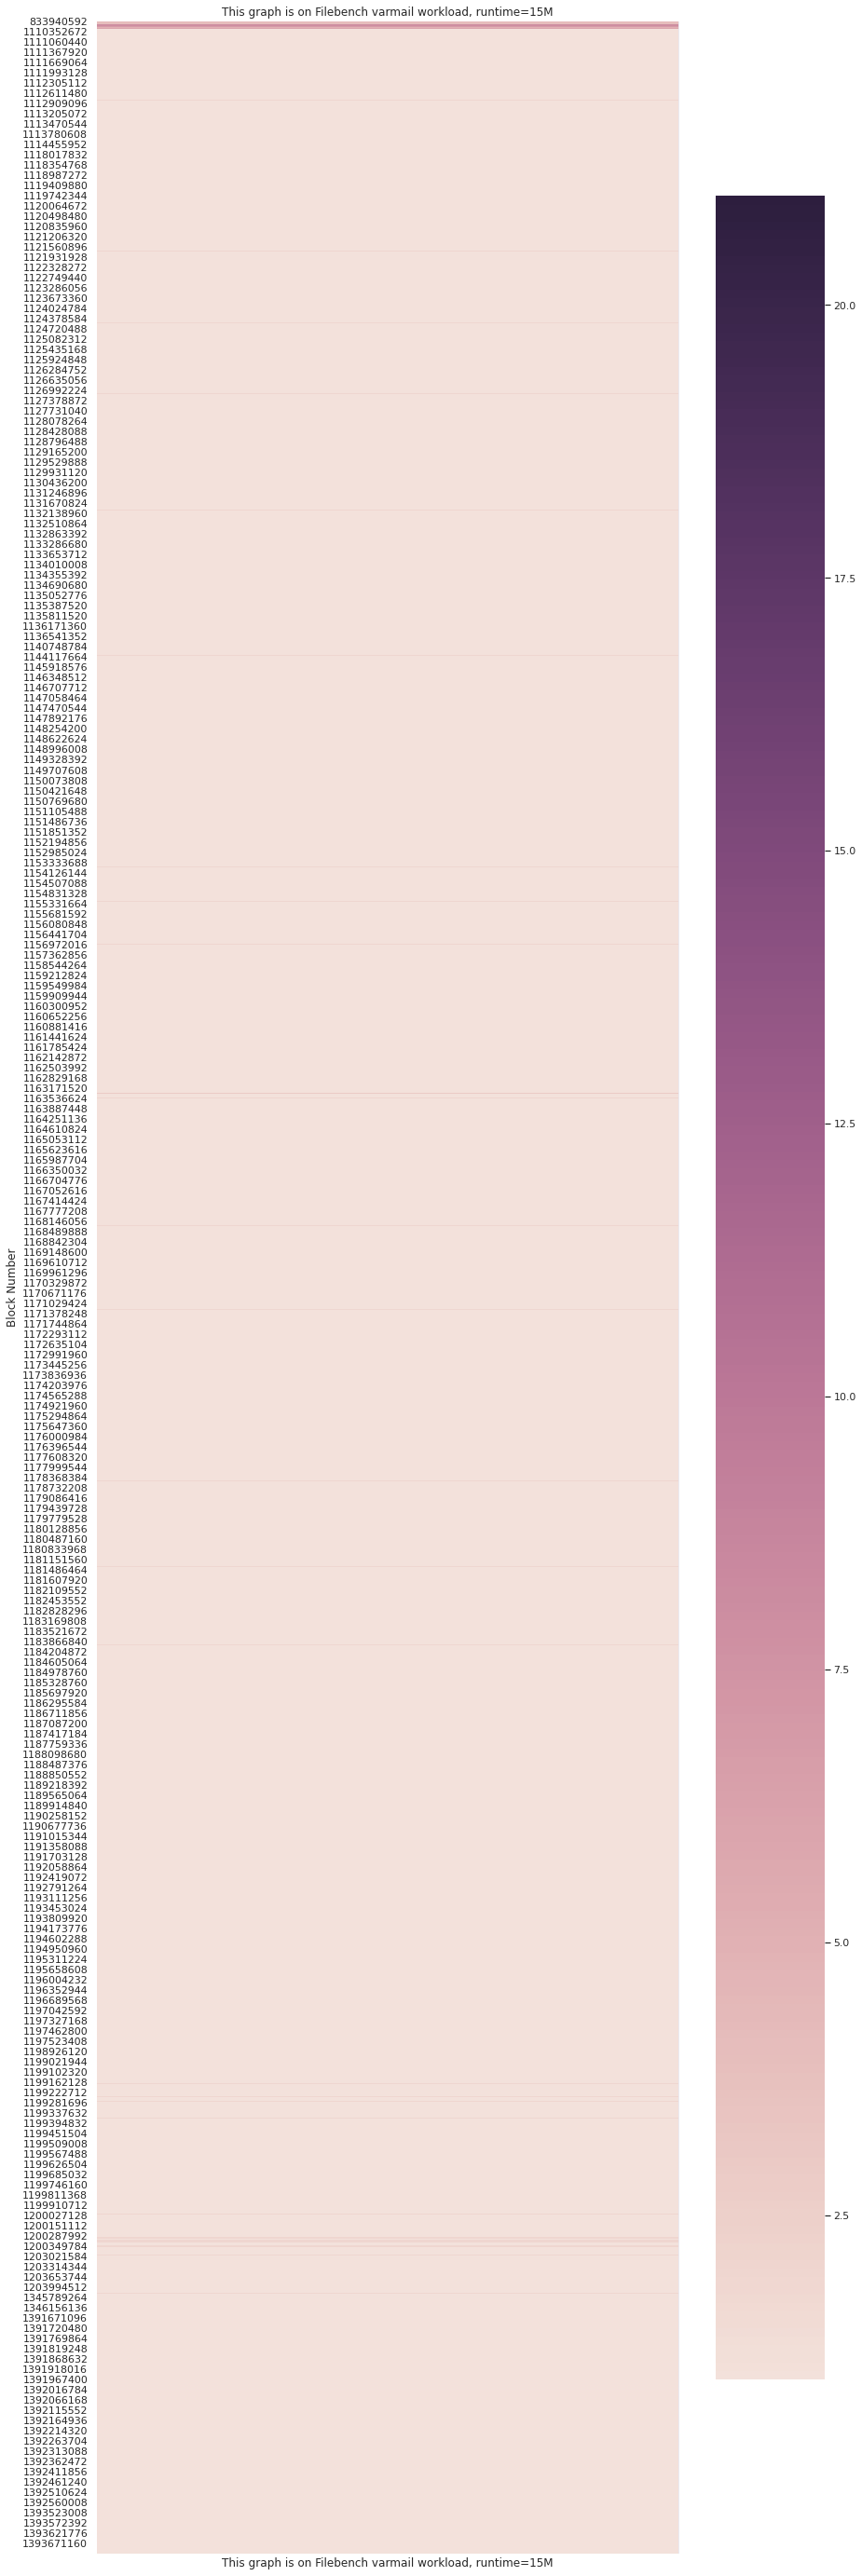

In [14]:
sns.set(rc={'figure.figsize':(14,50)})

cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)

heatmap = sns.heatmap(sorted_df, cmap=cmap_i, xticklabels=False)
plt.xlabel('This graph is on Filebench varmail workload, runtime=15M')
plt.ylabel('Block Number')

plt.title('This graph is on Filebench varmail workload, runtime=15M')
plt.show()

### Plot of number of reads and writes wrt each block

In [ ]:
sns.set(rc={'figure.figsize':(14,50)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(sorted_read_df, cmap=cmap_i, xticklabels=False)
plt.xlabel('This graph is on Filebench varmail workload, only READS, runtime=15M')
plt.ylabel('Block Number')

plt.title('This graph is on Filebench varmail workload, only READS, runtime=15M')
plt.show()


In [ ]:
sns.set(rc={'figure.figsize':(14,50)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(sorted_write_df, cmap=cmap_i, xticklabels=False)
plt.xlabel('This graph is on Filebench varmail workload, only WRITES, runtime=15M')
plt.ylabel('Block Number')

plt.title('This graph is on Filebench varmail workload, only WRITES, runtime=15M')
plt.show()

### Distribution Fucntions

In [14]:
block_range_2000_plus = 0
block_range_1000_2000 = 0
block_range_500_1000 = 0
block_range_100_500 = 0
block_range_50_100 = 0
block_range_10_50 = 0
block_range_2_10 = 0
block_range_1 = 0
block_range_0 = 0




io_range_2000_plus = 0
io_range_1000_2000 = 0
io_range_500_1000 = 0
io_range_100_500 = 0
io_range_50_100 = 0
io_range_10_50 = 0
io_range_2_10 = 0
io_range_1 = 0



list_block_access_desc = sorted(block_counter_dict.values(), reverse=True)

for i in list_block_access_desc:
    if i >= 2000:
        block_range_2000_plus += 1
        io_range_2000_plus += i
        
    elif i >= 1000 and i < 2000:
        block_range_1000_2000 += 1
        io_range_1000_2000 += i
        
    elif i >= 500 and i < 1000:
        block_range_500_1000 += 1
        io_range_500_1000 += i
        
    elif i >= 100 and i < 500:
        block_range_100_500 += 1
        io_range_100_500 += i
        
    elif i >= 50 and i < 100:
        block_range_50_100 += 1
        io_range_50_100 += i
        
    elif i >=10 and i <= 50:
        block_range_10_50 += 1
        io_range_10_50 += i
        
    elif i >=2 and i <= 10:
        block_range_2_10 += 1
        io_range_2_10 += i
        
    elif i == 1:
        block_range_1 += 1
        io_range_1 += i
        
total_number_of_blocks = max(block_counter_dict)
block_range_0 = (total_number_of_blocks - (len(block_counter_dict)))


print("block_range_2000_plus", block_range_2000_plus)
print("block_range_1000_2000", block_range_1000_2000)
print("block_range_500_1000", block_range_500_1000)
print("block_range_100_500", block_range_100_500)
print("block_range_50_100", block_range_50_100)
print("block_range_10_50", block_range_10_50)
print("block_range_2_10", block_range_2_10)
print("block_range_1", block_range_1)
print("block_range_0", block_range_0)

number_of_blocks_total_accessed = block_range_2000_plus + block_range_1000_2000 + block_range_500_1000 + block_range_100_500 + block_range_50_100 + block_range_10_50 + block_range_2_10 + block_range_1
print("sum of all accessed blocks = ", number_of_blocks_total_accessed)



print("\n\n\n")


print("io_range_2000_plus", io_range_2000_plus)
print("io_range_1000_2000", io_range_1000_2000)
print("io_range_500_1000", io_range_500_1000)
print("io_range_100_500", io_range_100_500)
print("io_range_50_100", io_range_50_100)
print("io_range_10_50", io_range_10_50)
print("io_range_2_10", io_range_2_10)
print("io_range_1", io_range_1)

total_IOs_block = io_range_2000_plus + io_range_1000_2000 + io_range_500_1000 + io_range_100_500 + io_range_50_100 + io_range_10_50 + io_range_2_10 + io_range_1
print("sum of all IOs = ", total_IOs_block)

block_range_2000_plus 0
block_range_1000_2000 0
block_range_500_1000 0
block_range_100_500 0
block_range_50_100 0
block_range_10_50 64
block_range_2_10 148288
block_range_1 12049376
block_range_0 1476094863
sum of all accessed blocks =  12197728




io_range_2000_plus 0
io_range_1000_2000 0
io_range_500_1000 0
io_range_100_500 0
io_range_50_100 0
io_range_10_50 728
io_range_2_10 456232
io_range_1 12049376
sum of all IOs =  12506336


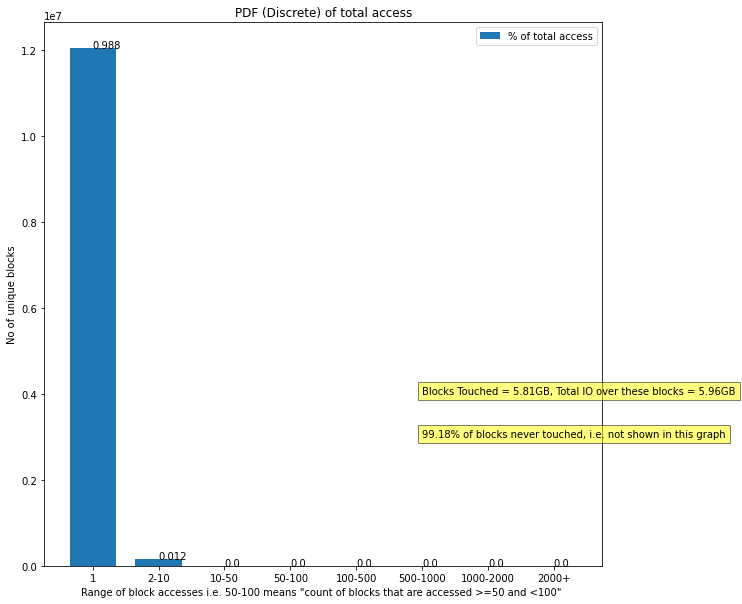

In [15]:
import matplotlib.pyplot as pyplot

pyplot.figure(figsize=(10,10))

x_axis = ["1", "2-10", "10-50", "50-100", "100-500", "500-1000", "1000-2000", "2000+"]

y_axis = [block_range_1, block_range_2_10, block_range_10_50,
          block_range_50_100, block_range_100_500, block_range_500_1000,
          block_range_1000_2000, block_range_2000_plus]

pyplot.bar(x_axis, y_axis, width=0.7, label='% of total access')
# pyplot.bar(x_h, host_read_latency, width=0.7, label='Oasis')
# pyplot.xticks([])
pyplot.legend(loc='upper right')
pyplot.title("PDF (Discrete) of total access")
pyplot.ylabel('No of unique blocks')
pyplot.xlabel('Range of block accesses i.e. 50-100 means "count of blocks that are accessed >=50 and <100" ')
pyplot.text(5, 3000000, "99.18% of blocks never touched, i.e. not shown in this graph", bbox=dict(facecolor='yellow', alpha=0.5))
pyplot.text(5, 4000000, "Blocks Touched = 5.81GB, Total IO over these blocks = 5.96GB", bbox=dict(facecolor='yellow', alpha=0.5))


for i in range(len(x_axis)):
    pyplot.annotate(str(round(y_axis[i]/number_of_blocks_total_accessed, 3)), xy=(x_axis[i], y_axis[i]))



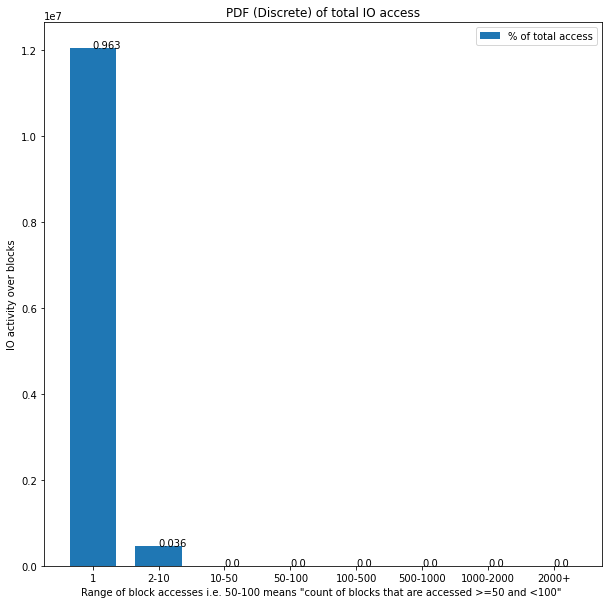

In [16]:
import matplotlib.pyplot as pyplot

pyplot.figure(figsize=(10,10))

x_axis = ["1", "2-10", "10-50", "50-100", "100-500", "500-1000", "1000-2000", "2000+"]

y_axis = [io_range_1, io_range_2_10, io_range_10_50,
          io_range_50_100, io_range_100_500, io_range_500_1000,
          io_range_1000_2000, io_range_2000_plus]

pyplot.bar(x_axis, y_axis, width=0.7, label='% of total access')
# pyplot.bar(x_h, host_read_latency, width=0.7, label='Oasis')
# pyplot.xticks([])
pyplot.legend(loc='upper right')
pyplot.title("PDF (Discrete) of total IO access")
pyplot.ylabel('IO activity over blocks')
pyplot.xlabel('Range of block accesses i.e. 50-100 means "count of blocks that are accessed >=50 and <100" ')
# pyplot.text(5, 150000, "99.982% of blocks never touched, i.e. not shown in this graph", bbox=dict(facecolor='yellow', alpha=0.5))

for i in range(len(x_axis)):
    pyplot.annotate(str(round(y_axis[i]/total_IOs_block, 3)), xy=(x_axis[i], y_axis[i]))



# Trace Analysis - time series plot

In [11]:
total_runtime = int(data_cleaned[-1:].Timestamp)

#Divide into 10 time periods
time_window = total_runtime/10
print("time window(sec) - ", time_window)

time window(sec) -  89.9


In [12]:
# we need to create 10 plots, each showing number of blocks and frequency usage of blocks
# the plots need to be cumulative over the 10 time_windows

list_of_block_counter_dict = count_blocks_time_window(data_cleaned, time_window)


In [13]:
for i in range(0, len(list_of_block_counter_dict)):
    print("List_Index_#%s"%i, "Totl blocks = ", len(list_of_block_counter_dict[i]),
          "and Total IO = ", sum(list_of_block_counter_dict[i].values()) )

List_Index_#0 Totl blocks =  1149176 and Total IO =  1152328
List_Index_#1 Totl blocks =  2284880 and Total IO =  2307200
List_Index_#2 Totl blocks =  3538088 and Total IO =  3563728
List_Index_#3 Totl blocks =  4843528 and Total IO =  4900352
List_Index_#4 Totl blocks =  6087440 and Total IO =  6169728
List_Index_#5 Totl blocks =  7434488 and Total IO =  7528072
List_Index_#6 Totl blocks =  8688344 and Total IO =  8827064
List_Index_#7 Totl blocks =  9927984 and Total IO =  10091880
List_Index_#8 Totl blocks =  11088920 and Total IO =  11315672
List_Index_#9 Totl blocks =  12197728 and Total IO =  12506336


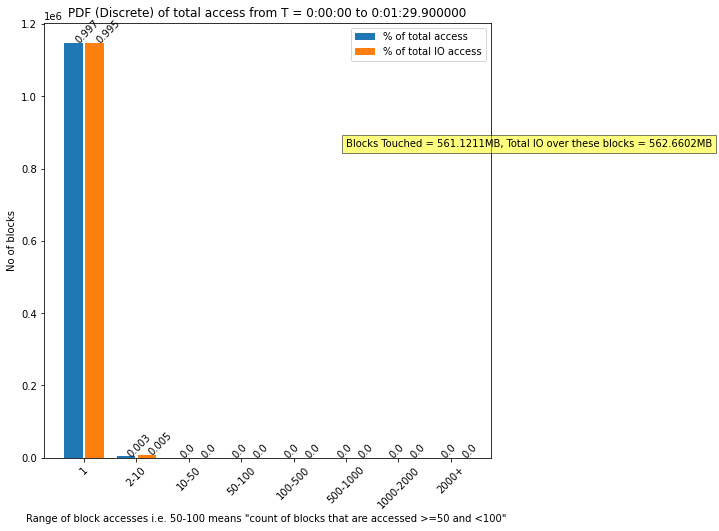

<Figure size 432x288 with 0 Axes>

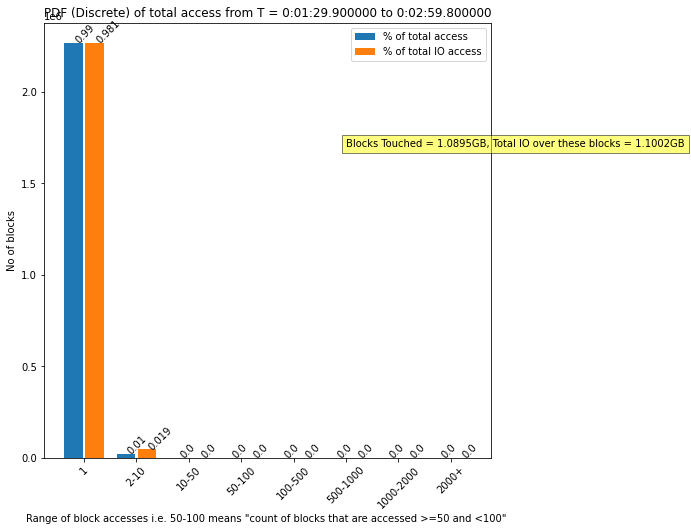

<Figure size 432x288 with 0 Axes>

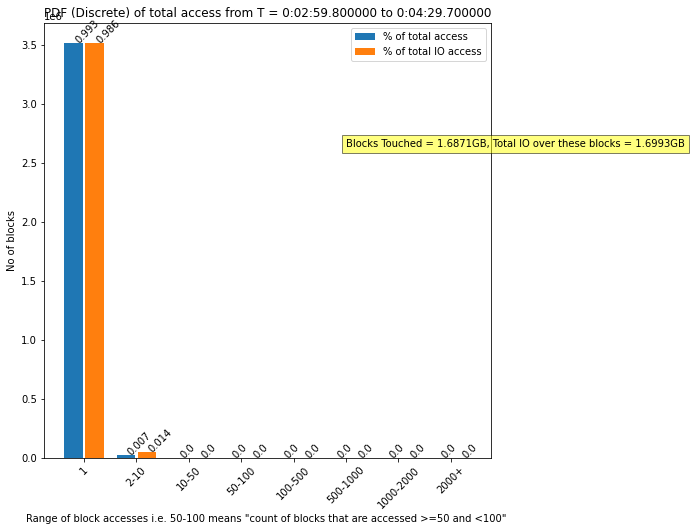

<Figure size 432x288 with 0 Axes>

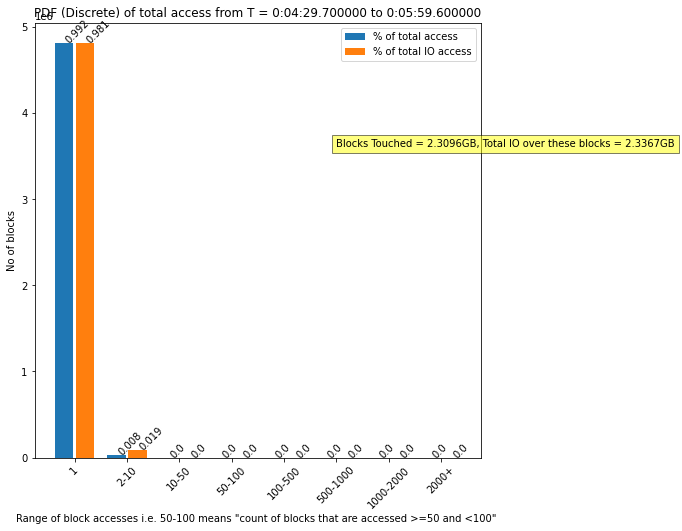

<Figure size 432x288 with 0 Axes>

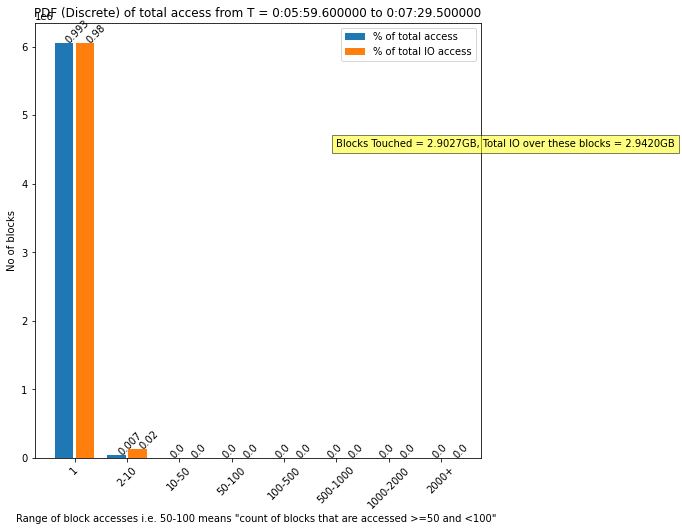

<Figure size 432x288 with 0 Axes>

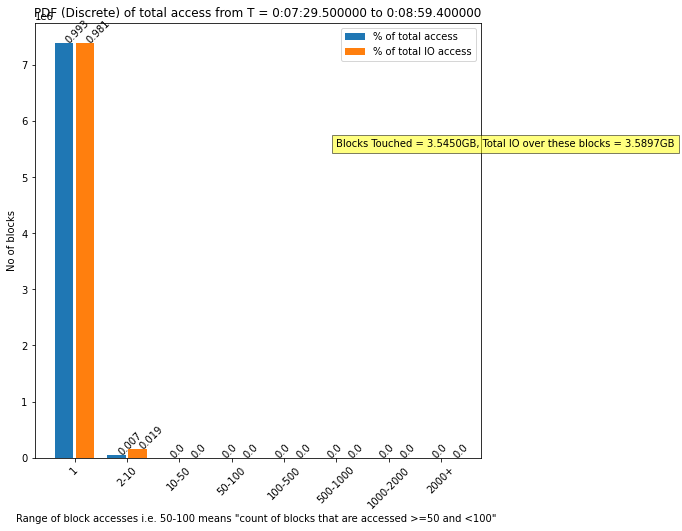

<Figure size 432x288 with 0 Axes>

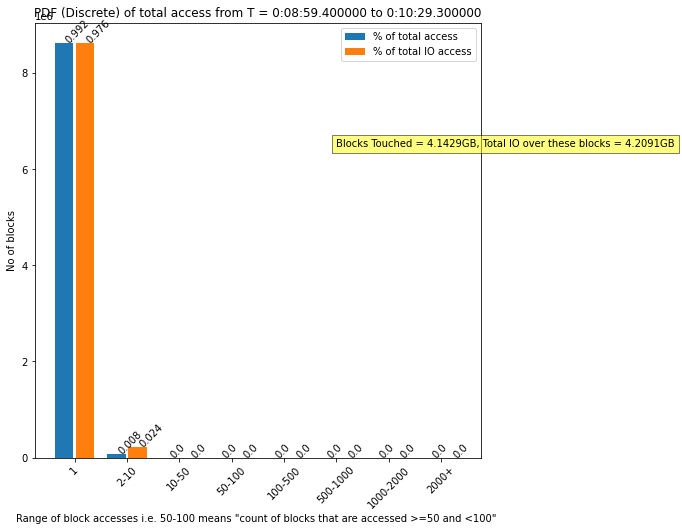

<Figure size 432x288 with 0 Axes>

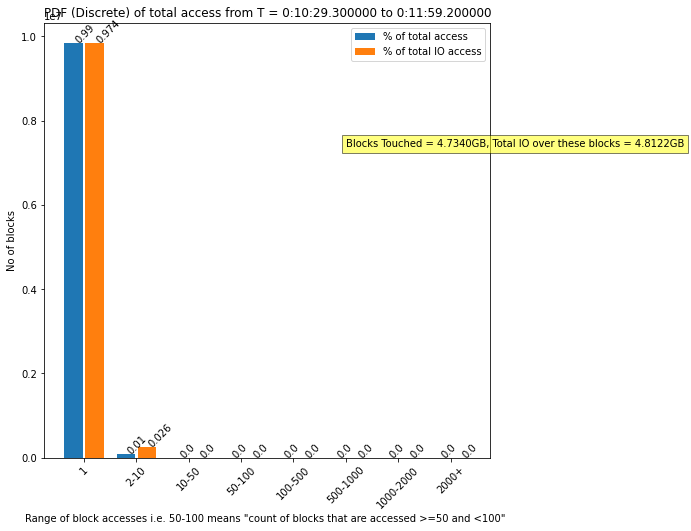

<Figure size 432x288 with 0 Axes>

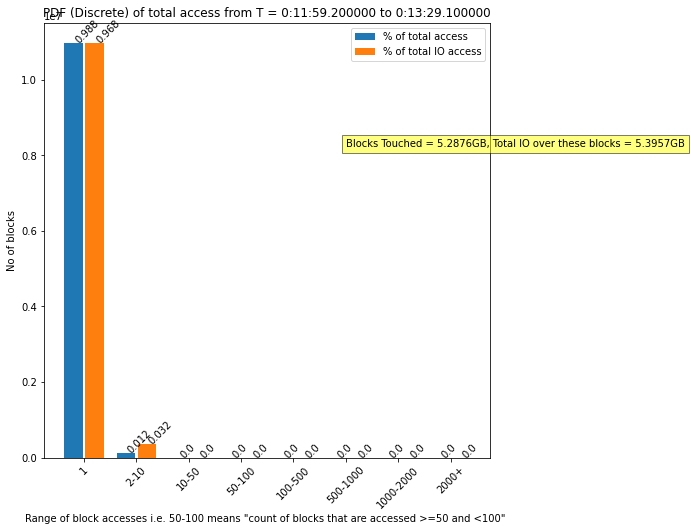

<Figure size 432x288 with 0 Axes>

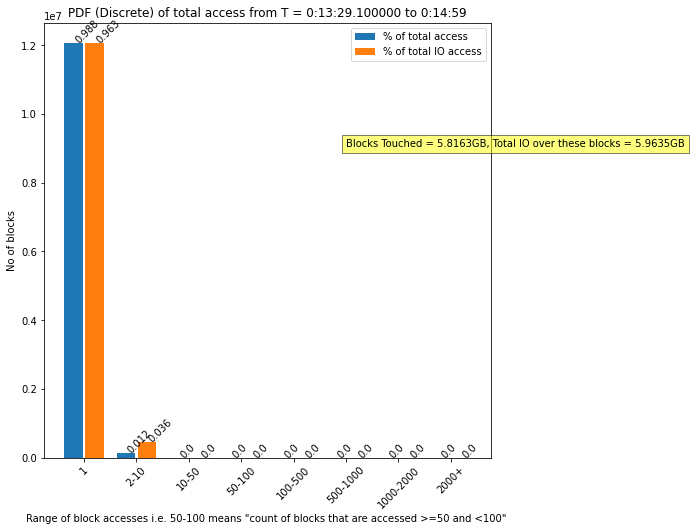

<Figure size 432x288 with 0 Axes>

In [14]:
for i in range(0, len(list_of_block_counter_dict)):
    list_block_range, list_io_range = block_range_count(list_of_block_counter_dict[i])
    fig = plot_dual_bar_graph(list_block_range, list_io_range, i, time_window)
    fig.show()